In [1]:
import numpy as np
import jax.numpy as jnp

from objectives import get_grape_fidelity_func

## Configure to use JAX

In [2]:
from qiskit_dynamics.array import Array

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

# set default backend
Array.set_default_backend('jax')

## Build model operators

Here we set up a duffing oscillator model in the rotating frame of an on-resonance drive frequency, after the RWA:
\begin{equation}
    H(t) = 2\pi\delta_0 a^\dagger a+\pi \alpha a^\dagger a (a^\dagger a - 1) + 2 \pi r(1+\delta_1)[ c_x(t) (a + a^\dagger) + c_y(t) i(a - a^\dagger)].
\end{equation}
where
- $\delta_0$ is the difference between the qubit frequency and drive frequency
-$\delta_1$ is similar to a variation in transfer function
- $\alpha$ is the anharmonicity
- $r$ is the drive strength, and
- $c_x(t)$ and $c_y(t)$ are the x and y control fields

In [3]:
dim = 4 # dimension cutoff for oscillators

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)


# model parameters - work in units of GHz/ns
anharm = -0.33
drive_strength = 0.02

# drift Hamiltonian on resonance
H0 = Array(np.pi * anharm * numb * (numb - jnp.eye(dim)))

# control terms - X and Y multiplied by 2 pi * drive_strength
Hc = Array(2 * np.pi * drive_strength * jnp.array([osc_X, osc_Y]))
perturb = Array(-1j*2*np.pi*numb) #the 0th perturbation

X = Array([[0., 1.], [1., 0.]], dtype=complex)
Utarget = X

Alist = -1j * Hc
D = -1j * H0

dt_filter = 0.125

#get fidelity function
fid_func = get_grape_fidelity_func(X)

## Set up signal parameterization

Maybe want to put `get_param_to_signal` here explicitly.

In [4]:
from discrete_signals import get_param_to_signal

In [5]:
# choose the size of the legendre basis
leg_order = 4
# choose # steps of the signal
N = 25

#get the filter
param_to_signal = get_param_to_signal(leg_order, N)

## Demonstrate approximation for 2 perturbations

First generate example parameters

In [6]:
from qiskit_dynamics import DiscreteSignal, Solver

#randomly generate a signal in the legendre basis
param = jnp.array(np.random.rand(2,leg_order + 1))

#get the signal
signal = param_to_signal(param)

#signal1 = signal[:,0]
#signal2 = signal[:,1]
signal1 = signal.real
signal2 = signal.imag

T = dt_filter*len(signal1) #28.125 for (4,25)

pc1 = DiscreteSignal(dt=dt_filter, samples=signal1,carrier_freq=0.)
pc2 = DiscreteSignal(dt=dt_filter, samples=signal2,carrier_freq=0.)
operators = [H0, Hc[0], Hc[1], 1j*perturb]
solver = Solver(hamiltonian_operators=Array(operators))

Compute the multi-variable Magnus expansion up to order 5.

In [7]:
%%time

from qiskit_dynamics.perturbation import solve_lmde_perturbation

def G(t):#the generator
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

#the 1st perturbation
def A0(t):
    return perturb

# the 2nd perturbation - transfer function variation
def A1(t):
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(c1*Hc[0] + c2*Hc[1])

results = solve_lmde_perturbation(
    perturbations=[A0, A1],
    t_span=[0, T],
    expansion_method='magnus',
    expansion_order=5,
    generator=G,
    integration_method='jax_odeint',
    rtol=1e-13,
    atol=1e-13
)

CPU times: user 7.88 s, sys: 106 ms, total: 7.98 s
Wall time: 8.41 s


Construct `ArrayPolynomial` to evaluate Magnus expansion to various orders.

In [8]:
U = results.y[-1]

from qiskit_dynamics.perturbation import ArrayPolynomial

term_labels = results.perturbation_results.expansion_labels
perturbation_terms = results.perturbation_results.expansion_terms

# first order expansion
n_terms = list(map(lambda x: len(x) <= 1, term_labels)).count(True)
magnus_expansion1 = ArrayPolynomial(
    array_coefficients=perturbation_terms[:n_terms, -1],
    monomial_labels=term_labels[:n_terms]
)

# second order expansion
n_terms = list(map(lambda x: len(x) <= 2, term_labels)).count(True)
magnus_expansion2 = ArrayPolynomial(
    array_coefficients=perturbation_terms[:n_terms, -1],
    monomial_labels=term_labels[:n_terms]
)

# third order polynomial
n_terms = list(map(lambda x: len(x) <= 3, term_labels)).count(True)
magnus_expansion3 = ArrayPolynomial(
    array_coefficients=perturbation_terms[:n_terms, -1],
    monomial_labels=term_labels[:n_terms]
)

# fourth order polynomial
n_terms = list(map(lambda x: len(x) <= 4, term_labels)).count(True)
magnus_expansion4 = ArrayPolynomial(
    array_coefficients=perturbation_terms[:n_terms, -1],
    monomial_labels=term_labels[:n_terms]
)

# fifth order polynomial
n_terms = list(map(lambda x: len(x) <= 5, term_labels)).count(True)
magnus_expansion5 = ArrayPolynomial(
    array_coefficients=perturbation_terms[:n_terms, -1],
    monomial_labels=term_labels[:n_terms]
)

magnus_expansions = [
    magnus_expansion1, 
    magnus_expansion2, 
    magnus_expansion3, 
    magnus_expansion4,
    magnus_expansion5
]

Compute error estimates over a range of values of $c1$ and $c2$ using the Magnus approximation.

In [9]:
from functools import partial
from jax import jit
from jax.scipy.linalg import expm as jexpm

# get the 2nd to 5th order approximate error rates using the Magnus terms
@partial(jit, static_argnums=(2,))
def err_est(c1, c2, order):
    
    coeffs = jnp.array([c1, c2])
    
    U_approx = U @ jexpm(magnus_expansions[order - 1](coeffs).data)
    
    fid = fid_func(U_approx).data
    return 1. - fid 

z_vals = jnp.linspace(-1.5*drive_strength, 1.5*drive_strength, 20)
v_vals = jnp.linspace(-0.2, 0.2, len(z_vals))
err_estimate1 = [err_est(z,v,1) for v in v_vals for z in z_vals]
err_estimate2 = [err_est(z,v,2) for v in v_vals for z in z_vals]
err_estimate3 = [err_est(z,v,3) for v in v_vals for z in z_vals]
err_estimate4 = [err_est(z,v,4) for v in v_vals for z in z_vals]
err_estimate5 = [err_est(z,v,5) for v in v_vals for z in z_vals]

Compute fidelity using direct simulation.

In [12]:
from jax import vmap

tol = 1e-8

#exact error with the two perturbations
def exact_err(args):
    c1,c2 = args
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal1,carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal2,carrier_freq=0.)
    signals2 = [1., pc1_, pc2_, Array(c1)]
    solver_copy = solver.copy()
    solver_copy.signals = signals2
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    return 1. - fid_func(time_results.y[-1]).data

err_exact = vmap(exact_err)((jnp.tile(z_vals,len(v_vals)),jnp.repeat(v_vals,len(z_vals))))

In [10]:
# helper function for 2D meshplots
def cell_centered(arr_in):
    arr_out = np.empty(len(arr_in)+1)
    dist = arr_in[1] - arr_in[0]
    for i in range(len(arr_in)):
        arr_out[i] = arr_in[i] - dist/2
    arr_out[-1] = arr_in[-1] + dist/2
    return arr_out

In [31]:
totest = diff5
print(max(totest))
print(min(totest))

0.4092479606717998
-0.04634475638145974


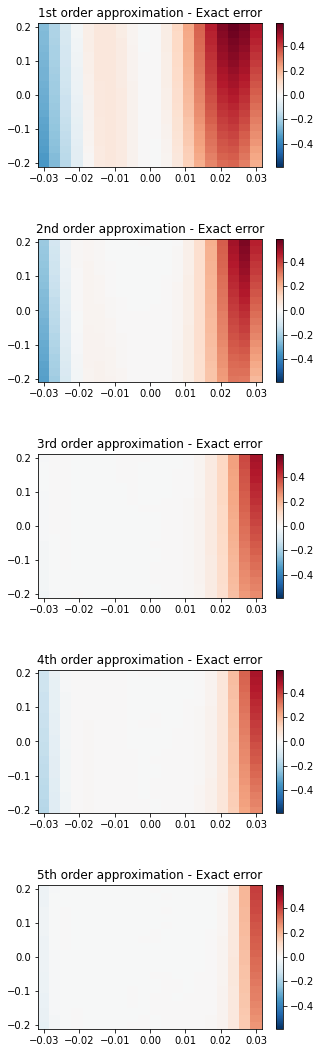

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

#plot the differences between estimates and exact error
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
diff1 = jnp.array(err_estimate1) - err_exact
diff2 = jnp.array(err_estimate2) - err_exact
diff3 = jnp.array(err_estimate3) - err_exact
diff4 = jnp.array(err_estimate4) - err_exact
diff5 = jnp.array(err_estimate5) - err_exact

x_cell = cell_centered(z_vals)
y_cell = cell_centered(v_vals)
cb_min = -0.59
cb_max = 0.59

im1 = ax1.pcolormesh(x_cell, y_cell, diff1.reshape(len(z_vals),len(v_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im2 = ax2.pcolormesh(x_cell, y_cell, diff2.reshape(len(z_vals),len(v_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im3 = ax3.pcolormesh(x_cell, y_cell, diff3.reshape(len(z_vals),len(v_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im4 = ax4.pcolormesh(x_cell, y_cell, diff4.reshape(len(z_vals),len(v_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im5 = ax5.pcolormesh(x_cell, y_cell, diff5.reshape(len(z_vals),len(v_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
#ax0.title.set_text('Exact error')
ax1.title.set_text('1st order approximation - Exact error')
ax2.title.set_text('2nd order approximation - Exact error')
ax3.title.set_text('3rd order approximation - Exact error')
ax4.title.set_text('4th order approximation - Exact error')
ax5.title.set_text('5th order approximation - Exact error')
#fig.colorbar(im0, ax=ax0)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
fig.colorbar(im4, ax=ax4)
fig.colorbar(im5, ax=ax5)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
fig.set_size_inches(5, 18.5) #change these numbers to adjust the plots
plt.show()

Text(0, 0.5, 'Error')

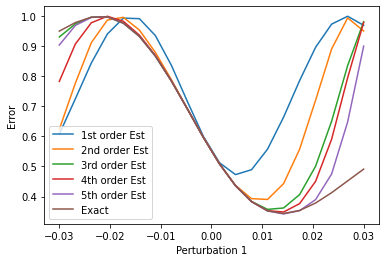

In [15]:
#Plot the diagonal of the 2D plot above
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err1 = [jnp.array(err_estimate1).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]

plt.plot(z_vals, dia_err1,label='1st order Est')
plt.plot(z_vals, dia_err2,label='2nd order Est')
plt.plot(z_vals, dia_err3,label='3rd order Est')
plt.plot(z_vals, dia_err4,label='4th order Est')
plt.plot(z_vals, dia_err5,label='5th order Est')
plt.plot(z_vals, dia_err_exact,label='Exact')
plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Error')

# investigate scaling in the number of parameters

In [14]:
magnus_order = 3

#random inputs
inputs = jnp.array(np.random.rand(10, 2, leg_order + 1))

# drift Hamiltonian on resonance
H0 = Array(np.pi * anharm * numb * (numb - jnp.eye(dim)))

# control terms - X and Y multiplied by 2 pi * drive_strength
Hc = Array(2 * np.pi * drive_strength * jnp.array([osc_X, osc_Y]))
perturb0 = Array(-1j * 2 * np.pi * numb)
#perturb1 = -1j*(c1*Hc[0] + c2*Hc[1])
perturb2 = Array(-1j * np.pi * numb * (numb - jnp.eye(dim)))
perturb3 = Array(-1j * 2 * np.pi * osc_X)
perturb4 = Array(-1j * 2 * np.pi * osc_Y)
#perturb5 = -1j*(c1**2*Hc[0])   #c**2 * (a + adag)
perturb6 = Array(-1j * np.pi * anharm * numb * (numb - jnp.eye(dim)) * (numb - 2 * jnp.eye(dim)))

# 1. resonant frequency uncertainty * perturb0
# 2. anharmonicity uncertainty * perturb2
# 3. drive strength uncertainty 1 * perturb3
# 4. drive strength uncertainty 2 (or, amplitude/phase) * perturb4
# 5. c**2 * (a + adag) or c * (a + adag)**2 * 
# 6. anharmonicity of higher levels, uncertainty in drive strength between different levels *

In [15]:
from scipy.signal import gaussian

n_samples = 5

gaussian1 = jnp.array(gaussian(n_samples, n_samples/5))
gaussian1 /= jnp.sum(gaussian1) #normalize the distribution
gaussian2 = jnp.kron(gaussian1,gaussian1)
gaussian3 = jnp.kron(gaussian2,gaussian1)
gaussian4 = jnp.kron(gaussian3,gaussian1)
gaussian5 = jnp.kron(gaussian4,gaussian1)
gaussian6 = jnp.kron(gaussian5,gaussian1)
gaussian7 = jnp.kron(gaussian6,gaussian1)


#objective function defined with the approximate fid curve, 1 variation
def magnus_obj0(param1, p0_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])
    
    results = solve_lmde_perturbation(
        perturbations=[A0],
        expansion_method='magnus',
        expansion_order=magnus_order,
        t_span=[0, T],
        generator=G_,
        integration_method='jax_odeint',
        rtol=tol,
        atol=tol
    )
    U = results.y[-1]
    
    # Construct magnus expansion
    perturb_terms = results.perturbation_results.expansion_terms[:, -1]
    term_labels = results.perturbation_results.expansion_labels
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=perturb_terms,
        monomial_labels=term_labels
    )
    def err_est(args):
        coeffs = jnp.array([args])
        U_approx = U @ jexpm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data
    
    err_estimate = vmap(err_est)(p0_vals)
    return Array(jnp.sum(err_estimate * gaussian1)).data

#objective function defined with the approximate fid curve, 2 variations
def magnus_obj1(param1, p0_vals, p1_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt= dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])
    
    results = solve_lmde_perturbation(
        perturbations=[A0, A1_],
        expansion_method='magnus',
        expansion_order=magnus_order,
        t_span=[0, T],
        generator=G_,
        integration_method='jax_odeint',
        rtol=tol,
        atol=tol
    )
    U = results.y[-1]
    perturb_terms = results.perturbation_results.expansion_terms[:, -1]
    term_labels = results.perturbation_results.expansion_labels
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=perturb_terms,
        monomial_labels=term_labels
    )
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ jexpm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = np.kron(p0_vals, np.ones(5))
    p1_repeated = np.kron(np.ones(5), p1_vals)
    err_estimate = vmap(err_est)((p0_repeated ,p1_repeated))
    return Array(jnp.sum(err_estimate * gaussian2)) .data

#objective function defined with the approximate fid curve, 3 variations
def magnus_obj2(param1, p0_vals, p1_vals, p2_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    results = solve_lmde_perturbation(
        perturbations=[A0, A1_, A2_],
        expansion_method='magnus',
        expansion_order=magnus_order,
        t_span=[0, T],
        generator=G_,
        integration_method='jax_odeint',
        rtol=tol,
        atol=tol
    )
    U = results.y[-1]

    perturb_terms = results.perturbation_results.expansion_terms[:, -1]
    term_labels = results.perturbation_results.expansion_labels
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=perturb_terms,
        monomial_labels=term_labels
    )
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ jexpm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(25))
    p1_repeated = jnp.kron( jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5))
    p2_repeated = jnp.kron(jnp.ones(25), p2_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated))
    return Array(jnp.sum(err_estimate * gaussian3)).data

#objective function defined with the approximate fid curve, 4 variations
def magnus_obj3(param1, p0_vals, p1_vals, p2_vals, p3_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3
    
    results = solve_lmde_perturbation(
        perturbations=[A0, A1_, A2_, A3_],
        expansion_method='magnus',
        expansion_order=magnus_order,
        t_span=[0, T],
        generator=G_,
        integration_method='jax_odeint',
        rtol=tol,
        atol=tol
    )
    U = results.y[-1]
    #construct Magnus polynomial
    perturb_terms = results.perturbation_results.expansion_terms[:, -1]
    term_labels = results.perturbation_results.expansion_labels
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=perturb_terms,
        monomial_labels=term_labels
    )
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ jexpm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**3))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**2))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5))
    p3_repeated = jnp.kron(jnp.ones(5**3), p3_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated))
    return Array(jnp.sum(err_estimate * gaussian4)).data


#objective function defined with the approximate fid curve, 5 variations
def magnus_obj4(param1, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3

    def A4_(t):
        return perturb4
    
    results = solve_lmde_perturbation(
        perturbations=[A0, A1_, A2_, A3_, A4_],
        expansion_method='magnus',
        expansion_order=magnus_order,
        t_span=[0, T],
        generator=G_,
        integration_method='jax_odeint',
        rtol=tol,
        atol=tol
    )
    U = results.y[-1]
    #construct Magnus polynomial
    perturb_terms = results.perturbation_results.expansion_terms[:, -1]
    term_labels = results.perturbation_results.expansion_labels
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=perturb_terms,
        monomial_labels=term_labels
    )
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ jexpm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**4))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**3))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**2))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5))
    p4_repeated = jnp.kron(jnp.ones(5**4), p4_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated))
    return Array(jnp.sum(err_estimate * gaussian5)).data

#6 variations
def magnus_obj5(param1, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3

    def A4_(t):
        return perturb4

    def A5_(t):
        c1 = pc1_(t)
        return -1j*(c1**2*Hc[0])
    
    results = solve_lmde_perturbation(
        perturbations=[A0, A1_, A2_, A3_, A4_, A5_],
        expansion_method='magnus',
        expansion_order=magnus_order,
        t_span=[0, T],
        generator=G_,
        integration_method='jax_odeint',
        rtol=tol,
        atol=tol
    )
    U = results.y[-1]
    #construct Magnus polynomial
    perturb_terms = results.perturbation_results.expansion_terms[:, -1]
    term_labels = results.perturbation_results.expansion_labels
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=perturb_terms,
        monomial_labels=term_labels
    )
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ jexpm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**5))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**4))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**3))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5**2))
    p4_repeated = jnp.kron(jnp.kron(jnp.ones(5**4), p4_vals), jnp.ones(5))
    p5_repeated = jnp.kron(jnp.ones(5**5), p5_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated))
    return Array(jnp.sum(err_estimate * gaussian6)).data

#7 variations
def magnus_obj6(param1, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, p6_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3

    def A4_(t):
        return perturb4

    def A5_(t):
        c1 = pc1_(t)
        return -1j*(c1**2*Hc[0])
    
    def A6_(t):
        return perturb6
    
    
    results = solve_lmde_perturbation(
        perturbations=[A0, A1_, A2_, A3_, A4_, A5_, A6_],
        expansion_method='magnus',
        expansion_order=magnus_order,
        t_span=[0, T],
        generator=G_,
        integration_method='jax_odeint',
        rtol=tol,
        atol=tol
    )
    U = results.y[-1]
    
    #construct Magnus polynomial
    perturb_terms = results.perturbation_results.expansion_terms[:, -1]
    term_labels = results.perturbation_results.expansion_labels
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=perturb_terms,
        monomial_labels=term_labels
    )
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ jexpm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**6))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**5))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**4))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5**3))
    p4_repeated = jnp.kron(jnp.kron(jnp.ones(5**4), p4_vals), jnp.ones(5**2))
    p5_repeated = jnp.kron(jnp.kron(jnp.ones(5**5), p5_vals), jnp.ones(5))
    p6_repeated = jnp.kron(jnp.ones(5**6), p6_vals)

    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated, p6_repeated))
    return Array(jnp.sum(err_estimate * gaussian7)).data

Construct corresponding functions for full simulation over the grid.

Something weird is going on here in terms of frames, why are we not simulating in the rotating frame of $H_0$?

In [16]:
N_variations = np.arange(7) + 1

n_points = 5
scale = 0.01
p0_vals = jnp.linspace(-scale*drive_strength, scale*drive_strength, n_points)
p1_vals = jnp.linspace(-scale*drive_strength, scale*drive_strength, n_points)
p2_vals = jnp.linspace(-scale*drive_strength, scale*drive_strength, n_points)
p3_vals = jnp.linspace(-scale*drive_strength, scale*drive_strength, n_points)
p4_vals = jnp.linspace(-scale*drive_strength, scale*drive_strength, n_points)
p5_vals = jnp.linspace(-scale*drive_strength, scale*drive_strength, n_points)
p6_vals = jnp.linspace(-scale*drive_strength, scale*drive_strength, n_points)

In [17]:
from jax import jit, value_and_grad

from time import time

mag_jit_times = []
mag_ave_times = []
mag_ave_jitted_times = []

mag_obj_funcs = [lambda params: magnus_obj0(params, p0_vals),
                 lambda params: magnus_obj1(params, p0_vals, p1_vals),
                 lambda params: magnus_obj2(params, p0_vals, p1_vals, p2_vals),
                 lambda params: magnus_obj3(params, p0_vals, p1_vals, p2_vals, p3_vals),
                 lambda params: magnus_obj4(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals),
                 lambda params: magnus_obj5(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals),
                 lambda params: magnus_obj6(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, p6_vals)]

# only do first few for now
#n_perturb = 1
#mag_obj_funcs = mag_obj_funcs[:n_perturb]

for idx, obj_func in enumerate(mag_obj_funcs):
    print('Working on number ' + str(idx + 1) + '/' + str(len(mag_obj_funcs)))
    jit_grad_obj = jit(value_and_grad(obj_func))

    # measure time to jit/grad + one evaluation
    start = time()
    val = jit_grad_obj(inputs[0])[0].block_until_ready()
    mag_jit_times.append(time() - start)

    # average jitted run time over multiple inputs
    jitted_time = 0.
    for rand_in in inputs[1:]: 
        start = time()
        val = jit_grad_obj(rand_in)[0].block_until_ready()
        jitted_time += time() - start
    
    mag_ave_jitted_times.append(jitted_time / (len(inputs) - 1))
    mag_ave_times.append((mag_jit_times[-1] + jitted_time) / len(inputs))

Working on number 1/7
Working on number 2/7
Working on number 3/7
Working on number 4/7
Working on number 5/7
Working on number 6/7
Working on number 7/7


In [18]:
mag_ave_jitted_times

[1.2139752176072862,
 2.764206224017673,
 5.246069113413493,
 9.973127338621351,
 16.289368391036987,
 25.939017799165512,
 40.08011447058784]

Run corresponding simulations for direct evaluation.

Below is an attempt to bypass the current issue I'm having with combinations of odeint + scan/vmap + grad. Rather than construct the full objective (including summation over various parameter values), then differentiate it, we construct the objective for a single objective, differentiate it, then scan the derivative.

In [19]:
from jax.lax import scan

solver0 = Solver(hamiltonian_operators=[H0, Hc[0], Hc[1], 1j*perturb0])


def point_obj0(param2, p0_val):
    sig2 = param_to_signal(param2)
    
    c0 = p0_val
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig2[:,0], carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig2[:,1], carrier_freq=0.)
    signals = [1., pc1_, pc2_, Array(c0)]
    solver_copy = solver0.copy()
    solver_copy.signals = signals
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    return 1.- Array(fid_func(time_results.y[-1])).data

# differentiate with respect to first parameter
value_and_grad_point_obj0 = value_and_grad(point_obj0, argnums=0)

@jit
def dist_value_and_grad_point_obj0(param2):
    
    obj = 0.
    gradient = jnp.zeros_like(param2)
    
    def scan_f(carry, x):
        curr_obj, curr_gradient = carry
        p0_val = x
        point_obj, point_grad = value_and_grad_point_obj0(param2, x)
        new_obj = curr_obj + point_obj
        new_grad = curr_gradient + point_grad
        return (new_obj, new_grad), None

    val, gradient = scan(scan_f, init=(obj, gradient), xs=(p0_vals))[0]
    return val / 5**1, gradient / 5**1

def point_obj1(param2, p0_val, p1_val):
    sig2 = param_to_signal(param2)
    c0 = p0_val 
    c1 = p1_val
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
    signals = [1., pc1_, pc2_, Array(c0)]
    solver_copy = solver0.copy()
    solver_copy.signals = signals
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    return 1.- Array(fid_func(time_results.y[-1])).data

# differentiate with respect to first parameter
value_and_grad_point_obj1 = value_and_grad(point_obj1, argnums=0)

@jit
def dist_value_and_grad_point_obj1(param2):
    
    obj = 0.
    gradient = jnp.zeros_like(param2)
    
    def scan_f(carry, x):
        curr_obj, curr_gradient = carry
        p0_val, p1_val = x
        point_obj, point_grad = value_and_grad_point_obj1(param2, p0_val, p1_val)
        new_obj = curr_obj + point_obj
        new_grad = curr_gradient + point_grad
        return (new_obj, new_grad), None

    p0_repeated = np.kron(p0_vals, np.ones(5))
    p1_repeated = np.kron(np.ones(5), p1_vals)
    
    val, gradient = scan(scan_f, init=(obj, gradient), xs=(p0_repeated, p1_repeated))[0]
    return val / (5**2), gradient / (5**2)

solver2 = Solver(hamiltonian_operators=[H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2])

def point_obj2(param2, p0_val, p1_val, p2_val):
    sig2 = param_to_signal(param2)
    
    c0 = p0_val
    c1 = p1_val
    c2 = p2_val
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
    signals = [1., pc1_, pc2_, Array(c0), Array(c2)]
    solver_copy = solver2.copy()
    solver_copy.signals = signals
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    return 1.- Array(fid_func(time_results.y[-1])).data

# differentiate with respect to first parameter
value_and_grad_point_obj2 = value_and_grad(point_obj2, argnums=0)


@jit
def dist_value_and_grad_point_obj2(param2):
    
    obj = 0.
    gradient = jnp.zeros_like(param2)
    
    def scan_f(carry, x):
        curr_obj, curr_gradient = carry
        p0_val, p1_val, p2_val = x
        point_obj, point_grad = value_and_grad_point_obj2(param2, p0_val, p1_val, p2_val)
        new_obj = curr_obj + point_obj
        new_grad = curr_gradient + point_grad
        return (new_obj, new_grad), None

    p0_repeated = np.kron(p0_vals, np.ones(25))
    p1_repeated = np.kron(np.kron(np.ones(5), p1_vals), np.ones(5))
    p2_repeated = np.kron(np.ones(25), p2_vals)
    
    val, gradient = scan(scan_f, init=(obj, gradient), xs=(p0_repeated, p1_repeated, p2_repeated))[0]
    return val / (5**3), gradient / (5**3)
        
solver3 = Solver(
    hamiltonian_operators=[
        H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2, 1j * perturb3
    ]
)

def point_obj3(param2, p0_val, p1_val, p2_val, p3_val):
    sig2 = param_to_signal(param2)
    
    c0, c1, c2, c3 = (p0_val, p1_val, p2_val, p3_val)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
    signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3)]
    solver_copy = solver3.copy()
    solver_copy.signals = signals
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    time_results = solver_copy.solve(t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
    return 1.- Array(fid_func(time_results.y[-1])).data

# differentiate with respect to first parameter
value_and_grad_point_obj3 = value_and_grad(point_obj3, argnums=0)

@jit
def dist_value_and_grad_point_obj3(param2):
    
    obj = 0.
    gradient = jnp.zeros_like(param2)
    
    def scan_f(carry, x):
        curr_obj, curr_gradient = carry
        p0_val, p1_val, p2_val, p3_val = x
        point_obj, point_grad = value_and_grad_point_obj3(param2, p0_val, p1_val, p2_val, p3_val)
        new_obj = curr_obj + point_obj
        new_grad = curr_gradient + point_grad
        return (new_obj, new_grad), None

    p0_repeated = np.kron(p0_vals, np.ones(5**3))
    p1_repeated = np.kron(np.kron(np.ones(5), p1_vals), np.ones(5**2))
    p2_repeated = np.kron(np.kron(np.ones(5**2), p2_vals), np.ones(5))
    p3_repeated = np.kron(np.ones(5**3), p3_vals)
    
    val, gradient = scan(scan_f, init=(obj, gradient), xs=(
        p0_repeated, p1_repeated, p2_repeated, p3_repeated
    ))[0]
    return val / (5**4), gradient / (5**4)
        
solver4 = Solver(
    hamiltonian_operators=[
        H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2, 1j * perturb3, 1j * perturb4
    ]
)


def point_obj4(param2, p0_val, p1_val, p2_val, p3_val, p4_val):
    sig2 = param_to_signal(param2)
    
    c0, c1, c2, c3, c4 = (p0_val, p1_val, p2_val, p3_val, p4_val)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
    signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3), Array(c4)]
    solver_copy = solver4.copy()
    solver_copy.signals = signals
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    return 1.- Array(fid_func(time_results.y[-1])).data

# differentiate with respect to first parameter
value_and_grad_point_obj4 = value_and_grad(point_obj4, argnums=0)

@jit
def dist_value_and_grad_point_obj4(param2):
    
    obj = 0.
    gradient = jnp.zeros_like(param2)
    
    def scan_f(carry, x):
        curr_obj, curr_gradient = carry
        p0_val, p1_val, p2_val, p3_val, p4_val = x
        point_obj, point_grad = value_and_grad_point_obj4(
            param2, p0_val, p1_val, p2_val, p3_val, p4_val
        )
        new_obj = curr_obj + point_obj
        new_grad = curr_gradient + point_grad
        return (new_obj, new_grad), None

    p0_repeated = np.kron(p0_vals, np.ones(5**4))
    p1_repeated = np.kron(np.kron(np.ones(5), p1_vals), np.ones(5**3))
    p2_repeated = np.kron(np.kron(np.ones(5**2), p2_vals), np.ones(5**2))
    p3_repeated = np.kron(np.kron(np.ones(5**3), p3_vals), np.ones(5))
    p4_repeated = np.kron(np.ones(5**4), p4_vals)
    
    val, gradient = scan(scan_f, init=(obj, gradient), xs=(
        p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated
    ))[0]
    return val / (5**5), gradient / (5**5)

solver5 = Solver(
    hamiltonian_operators=[
        H0, 
        Hc[0], 
        Hc[1], 
        1j*perturb0, 
        1j*perturb2, 
        1j * perturb3, 
        1j * perturb4, 
        Hc[0]
    ]
)

def point_obj5(param2, p0_val, p1_val, p2_val, p3_val, p4_val, p5_val):
    sig2 = param_to_signal(param2)
    
    c0, c1, c2, c3, c4, c5 = (p0_val, p1_val, p2_val, p3_val, p4_val, p5_val)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
    signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3), Array(c4), pc1_ * pc1_ * Array(c5)]
    solver_copy = solver5.copy()
    solver_copy.signals = signals
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    return 1.- Array(fid_func(time_results.y[-1])).data
    
# differentiate with respect to first parameter
value_and_grad_point_obj5 = value_and_grad(point_obj5, argnums=0)

@jit
def dist_value_and_grad_point_obj5(param2):
    
    obj = 0.
    gradient = jnp.zeros_like(param2)
    
    def scan_f(carry, x):
        curr_obj, curr_gradient = carry
        p0_val, p1_val, p2_val, p3_val, p4_val, p5_val = x
        point_obj, point_grad = value_and_grad_point_obj5(
            param2, p0_val, p1_val, p2_val, p3_val, p4_val, p5_val
        )
        new_obj = curr_obj + point_obj
        new_grad = curr_gradient + point_grad
        return (new_obj, new_grad), None

    p0_repeated = np.kron(p0_vals, np.ones(5**5))
    p1_repeated = np.kron(np.kron(np.ones(5), p1_vals), np.ones(5**4))
    p2_repeated = np.kron(np.kron(np.ones(5**2), p2_vals), np.ones(5**3))
    p3_repeated = np.kron(np.kron(np.ones(5**3), p3_vals), np.ones(5**2))
    p4_repeated = np.kron(np.kron(np.ones(5**4), p4_vals), np.ones(5))
    p5_repeated = np.kron(np.ones(5**5), p5_vals)
    
    val, gradient = scan(scan_f, init=(obj, gradient), xs=(
        p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated
    ))[0]
    return val / (5**6), gradient / (5**6)

    
solver6 = Solver(
    hamiltonian_operators=[
        H0, 
        Hc[0], 
        Hc[1], 
        1j*perturb0, 
        1j*perturb2, 
        1j * perturb3, 
        1j * perturb4,
        Hc[0],
        1j * perturb6,
    ]
)

############
# are the signals here right?
############

def point_obj6(param2, p0_val, p1_val, p2_val, p3_val, p4_val, p5_val, p6_val):
    sig2 = param_to_signal(param2)
    
    c0, c1, c2, c3, c4, c5, c6 = (p0_val, p1_val, p2_val, p3_val, p4_val, p5_val, p6_val)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
    signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3), Array(c4), pc1_ * pc1_ * Array(c5), Array(c6)]
    solver_copy = solver6.copy()
    solver_copy.signals = signals
    time_results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=tol, 
        rtol=tol,
        method='jax_odeint'
    )
    return 1.- Array(fid_func(time_results.y[-1])).data


# differentiate with respect to first parameter
value_and_grad_point_obj6 = value_and_grad(point_obj6, argnums=0)

@jit
def dist_value_and_grad_point_obj6(param2):
    
    obj = 0.
    gradient = jnp.zeros_like(param2)
    
    def scan_f(carry, x):
        curr_obj, curr_gradient = carry
        p0_val, p1_val, p2_val, p3_val, p4_val, p5_val, p6_val = x
        point_obj, point_grad = value_and_grad_point_obj6(
            param2, p0_val, p1_val, p2_val, p3_val, p4_val, p5_val, p6_val
        )
        new_obj = curr_obj + point_obj
        new_grad = curr_gradient + point_grad
        return (new_obj, new_grad), None

    p0_repeated = np.kron(p0_vals, np.ones(5**6))
    p1_repeated = np.kron(np.kron(np.ones(5), p1_vals), np.ones(5**5))
    p2_repeated = np.kron(np.kron(np.ones(5**2), p2_vals), np.ones(5**4))
    p3_repeated = np.kron(np.kron(np.ones(5**3), p3_vals), np.ones(5**3))
    p4_repeated = np.kron(np.kron(np.ones(5**4), p4_vals), np.ones(5**2))
    p5_repeated = np.kron(np.kron(np.ones(5**5), p5_vals), np.ones(5))
    p6_repeated = np.kron(np.ones(5**6), p6_vals)
    
    val, gradient = scan(scan_f, init=(obj, gradient), xs=(
        p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated, p6_repeated
    ))[0]
    return val / (5**7), gradient / (5**7)

In [ ]:
from time import time

point_jit_times = []
point_ave_times = []
point_ave_jitted_times = []

point_obj_funcs = [
    dist_value_and_grad_point_obj0,
    dist_value_and_grad_point_obj1,
    dist_value_and_grad_point_obj2,
    dist_value_and_grad_point_obj3,
    dist_value_and_grad_point_obj4,
    dist_value_and_grad_point_obj5,
    dist_value_and_grad_point_obj6,
]

#point_obj_funcs = point_obj_funcs[-1:]

for idx, obj_func in enumerate(point_obj_funcs):
    print('Working on number ' + str(idx + 1) + '/' + str(len(point_obj_funcs)))

    # measure time to jit/grad + one evaluation
    start = time()
    val = obj_func(inputs[0])[0].block_until_ready()
    point_jit_times.append(time() - start)

    # average jitted run time over multiple inputs
    jitted_time = 0.
    for rand_in in inputs[1:]:
        start = time()
        val = obj_func(rand_in)[0].block_until_ready()
        jitted_time += time() - start
    
    point_ave_jitted_times.append(jitted_time / (len(inputs) - 1))
    point_ave_times.append((point_jit_times[-1] + jitted_time) / len(inputs))

Working on number 1/7
Working on number 2/7
Working on number 3/7
Working on number 4/7
Working on number 5/7


In [20]:
%%time 
value_and_grad_point_obj6(
    inputs[0], p0_vals[0], p1_vals[0], p2_vals[0], p3_vals[0], p4_vals[0], p5_vals[0], p6_vals[0]
)[0].block_until_ready()

CPU times: user 4.81 s, sys: 79.1 ms, total: 4.89 s
Wall time: 4.87 s


DeviceArray(0.30485382, dtype=float64)

In [21]:
%%time 
value_and_grad_point_obj6(
    inputs[0], p0_vals[0], p1_vals[0], p2_vals[0], p3_vals[0], p4_vals[0], p5_vals[0], p6_vals[0]
)[0].block_until_ready()

CPU times: user 3.14 s, sys: 32.1 ms, total: 3.17 s
Wall time: 3.14 s


DeviceArray(0.30485382, dtype=float64)